In [1]:
import cv2
import pandas as pd
import numpy as np
import imutils
from scipy.spatial import distance as dist
from imutils import perspective
from imutils import contours
import matplotlib.pyplot as plt

In [2]:
# using cam built-in to computer
videocapture=cv2.VideoCapture(1)

# using IP camera address from my mobile phone, with Android 'IP Webcam' app over WiFi
# videocapture=cv2.VideoCapture("http://xxx.xxx.xxx.xxx:8080/video")

def safe_div(x,y): # so we don't crash so often
    if y==0: return 0
    return x/y

def nothing(x): # for trackbar
    pass

def rescale_frame(frame, percent=25):  # make the video windows a bit smaller
    width = int(frame.shape[1] * percent/ 100)
    height = int(frame.shape[0] * percent/ 100)
    dim = (width, height)
    return cv2.resize(frame, dim, interpolation=cv2.INTER_AREA)

if not videocapture.isOpened():
    print("can't open camera")
    exit()
    
windowName="Webcam Live video feed"

cv2.namedWindow(windowName)

# Sliders to adjust image
# https://medium.com/@manivannan_data/set-trackbar-on-image-using-opencv-python-58c57fbee1ee
cv2.createTrackbar("threshold", windowName, 75, 255, nothing)
cv2.createTrackbar("kernel", windowName, 5, 30, nothing)
cv2.createTrackbar("iterations", windowName, 1, 10, nothing)

showLive=True
while(showLive):
    
    ret, frame=videocapture.read()
    frame_resize = rescale_frame(frame)
    if not ret:
        print("cannot capture the frame")
        exit()
   
    thresh= cv2.getTrackbarPos("threshold", windowName) 
    ret,thresh1 = cv2.threshold(frame_resize,thresh,255,cv2.THRESH_BINARY) 
    
    kern=cv2.getTrackbarPos("kernel", windowName) 
    kernel = np.ones((kern,kern),np.uint8) # square image kernel used for erosion
    
    itera=cv2.getTrackbarPos("iterations", windowName) 
    dilation =   cv2.dilate(thresh1, kernel, iterations=itera)
    erosion = cv2.erode(dilation,kernel,iterations = itera) # refines all edges in the binary image

    opening = cv2.morphologyEx(erosion, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)  
    closing = cv2.cvtColor(closing,cv2.COLOR_BGR2GRAY)
    
    _,contours,hierarchy = cv2.findContours(closing,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE) # find contours with simple approximation cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE

    closing = cv2.cvtColor(closing,cv2.COLOR_GRAY2RGB)
    cv2.drawContours(closing, contours, -1, (128,255,0), 1)
    
    # focus on only the largest outline by area
    areas = [] #list to hold all areas

    for contour in contours:
      ar = cv2.contourArea(contour)
      areas.append(ar)

    max_area = max(areas)
    max_area_index = areas.index(max_area)  # index of the list element with largest area

    cnt = contours[max_area_index - 1] # largest area contour is usually the viewing window itself, why?

    cv2.drawContours(closing, [cnt], 0, (0,0,255), 1)
    
    def midpoint(ptA, ptB): 
      return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

    # compute the rotated bounding box of the contour
    orig = frame_resize.copy()
    box = cv2.minAreaRect(cnt)
    box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
    box = np.array(box, dtype="int")
    
    # order the points in the contour such that they appear
    # in top-left, top-right, bottom-right, and bottom-left
    # order, then draw the outline of the rotated bounding
    # box
    box = perspective.order_points(box)
    cv2.drawContours(orig, [box.astype("int")], -1, (0, 255, 0), 1)
 
    # loop over the original points and draw them
    for (x, y) in box:
      cv2.circle(orig, (int(x), int(y)), 5, (0, 0, 255), -1)

    # unpack the ordered bounding box, then compute the midpoint
    # between the top-left and top-right coordinates, followed by
    # the midpoint between bottom-left and bottom-right coordinates
    (tl, tr, br, bl) = box
    (tltrX, tltrY) = midpoint(tl, tr)
    (blbrX, blbrY) = midpoint(bl, br)
     
    # compute the midpoint between the top-left and top-right points,
    # followed by the midpoint between the top-righ and bottom-right
    (tlblX, tlblY) = midpoint(tl, bl)
    (trbrX, trbrY) = midpoint(tr, br)
     
    # draw the midpoints on the image
    cv2.circle(orig, (int(tltrX), int(tltrY)), 5, (255, 0, 0), -1)
    cv2.circle(orig, (int(blbrX), int(blbrY)), 5, (255, 0, 0), -1)
    cv2.circle(orig, (int(tlblX), int(tlblY)), 5, (255, 0, 0), -1)
    cv2.circle(orig, (int(trbrX), int(trbrY)), 5, (255, 0, 0), -1)
     
    # draw lines between the midpoints
    cv2.line(orig, (int(tltrX), int(tltrY)), (int(blbrX), int(blbrY)),(255, 0, 255), 1)
    cv2.line(orig, (int(tlblX), int(tlblY)), (int(trbrX), int(trbrY)),(255, 0, 255), 1)
    cv2.drawContours(orig, [cnt], 0, (0,0,255), 1)
    
    # compute the Euclidean distance between the midpoints
    dA = dist.euclidean((tltrX, tltrY), (blbrX, blbrY))
    dB = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))

    # compute the size of the object
    pixelsPerMetric = 1 # more to do here to get actual measurements that have meaning in the real world
    dimA = dA / pixelsPerMetric
    dimB = dB / pixelsPerMetric
 
    # draw the object sizes on the image
    cv2.putText(orig, "{:.1f}mm".format(dimA), (int(tltrX - 15), int(tltrY - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (255, 255, 255), 2)
    cv2.putText(orig, "{:.1f}mm".format(dimB), (int(trbrX + 10), int(trbrY)), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (255, 255, 255), 2)

    # compute the center of the contour
    M = cv2.moments(cnt)
    cX = int(safe_div(M["m10"],M["m00"]))
    cY = int(safe_div(M["m01"],M["m00"]))
 
    # draw the contour and center of the shape on the image
    cv2.circle(orig, (cX, cY), 5, (255, 255, 255), -1)
    cv2.putText(orig, "center", (cX - 20, cY - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
 
    cv2.imshow(windowName, orig)
    cv2.imshow('', closing)
    if cv2.waitKey(30)>=0:
        showLive=False
        

        
videocapture.release()
cv2.destroyAllWindows()

can't open camera


AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
import numpy as np
import cv2

cap = cv2.VideoCapture(1)
#saveimg = []
while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()

    # Our operations on the frame come here
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    _ , imgThresh = cv2.threshold(gray,30,100,cv2.THRESH_BINARY)
    #saveimg.append(gray)

    # Display the resulting frame
    cv2.imshow('frame',gray)
    cv2.imshow('thresh',imgThresh)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(saveimg[40])

In [11]:
#cv2.imwrite("pendriveIMG2.jpg",saveimg[5])

In [41]:
img = cv2.imread("PICT0235.jpg",0)

In [42]:
#%matplotlib notebook

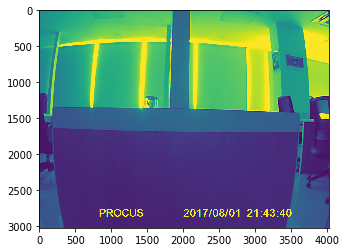

In [43]:
plt.imshow(img)

In [44]:
_ , imgThresh = cv2.threshold(img,30,100,cv2.THRESH_BINARY)
gauss = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,301,10)


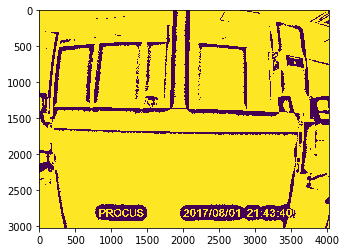

In [45]:
plt.imshow(gauss)

In [46]:
#PICT0227.jpg
tlup = [1617,1196]
trup = [2522,1202]
ml = [325,2172]
mr = [3797,2233]
bl = [382,2422]
br = [3739,2478]
allPoints = [tlup,trup,ml,mr,bl,br]

In [8]:
for i in allPoints:
    img = cv2.circle(img, tuple(i), 5, 0, 5)

In [47]:
#%matplotlib notebook

<IPython.core.display.Javascript object>


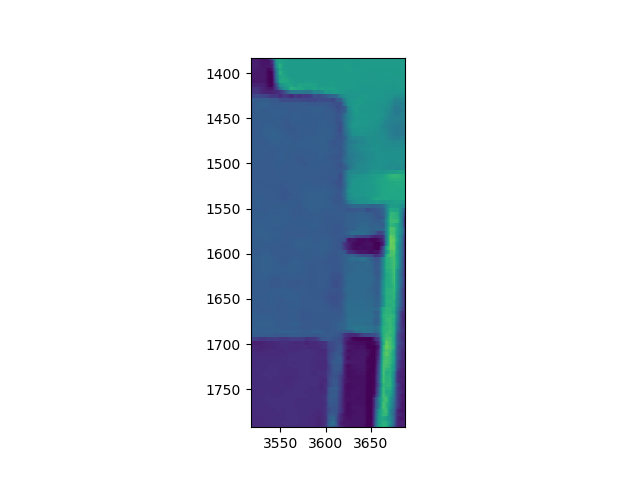

In [48]:
plt.imshow(img)

In [50]:
#PICT0235.jpg
tl = [193,1350]
tr = [3620,1430]
bl = [193,1638]
br = [3620,1690]
allPoints = [tl,tr,bl,br]

In [51]:
1203

1203

In [52]:
tl[0]

193

In [20]:
tr[0]

2522

In [58]:
#tl, tr, bl, br = allPoints[:4]
width = ( 1040 * (bl[0] - br[0])  * 3.3) / (3.2 * img.shape[0])
height = ( 1040 * (bl[1] - tl[1] )  * 3.3) / (3.2 * img.shape[0])

In [59]:
width

-1215.4290674603174

In [60]:
height

102.14285714285712

In [6]:
_,contours, hierarchy = cv2.findContours(imgThresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

In [7]:
len(contours)

1

In [8]:
cnts = sorted(contours, key=cv2.contourArea, reverse=True)

In [9]:
blank = np.zeros((imgThresh.shape[0],imgThresh.shape[1]))

In [10]:
blankCnt = cv2.drawContours(blank, cnts, 1, 255, 3)

error: OpenCV(3.4.5) C:\projects\opencv-python\opencv\modules\imgproc\src\drawing.cpp:2500: error: (-215:Assertion failed) 0 <= contourIdx && contourIdx < (int)last in function 'cv::drawContours'


In [11]:
plt.imshow(blankCnt)

NameError: name 'blankCnt' is not defined

In [12]:

def midpoint(ptA, ptB):
	return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)


In [13]:
for c in cnts:
# if the contour is not sufficiently large, ignore it
    if cv2.contourArea(c) < 100:
        continue

    # compute the rotated bounding box of the contour
    orig = imgThresh.copy()
    box = cv2.minAreaRect(c)
    box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
    box = np.array(box, dtype="int")

    # order the points in the contour such that they appear
    # in top-left, top-right, bottom-right, and bottom-left
    # order, then draw the outline of the rotated bounding
    # box
    box = perspective.order_points(box)
    cv2.drawContours(orig, [box.astype("int")], -1, (0, 255, 0), 2)

    # loop over the original points and draw them
    for (x, y) in box:
        cv2.circle(orig, (int(x), int(y)), 5, 255, 5)
        # unpack the ordered bounding box, then compute the midpoint
    # between the top-left and top-right coordinates, followed by
    # the midpoint between bottom-left and bottom-right coordinates
    (tl, tr, br, bl) = box
    (tltrX, tltrY) = midpoint(tl, tr)
    (blbrX, blbrY) = midpoint(bl, br)

    # compute the midpoint between the top-left and top-right points,
    # followed by the midpoint between the top-righ and bottom-right
    (tlblX, tlblY) = midpoint(tl, bl)
    (trbrX, trbrY) = midpoint(tr, br)

    # draw the midpoints on the image
    cv2.circle(orig, (int(tltrX), int(tltrY)), 5, (255, 0, 0), -1)
    cv2.circle(orig, (int(blbrX), int(blbrY)), 5, (255, 0, 0), -1)
    cv2.circle(orig, (int(tlblX), int(tlblY)), 5, (255, 0, 0), -1)
    cv2.circle(orig, (int(trbrX), int(trbrY)), 5, (255, 0, 0), -1)

    # draw lines between the midpoints
    cv2.line(orig, (int(tltrX), int(tltrY)), (int(blbrX), int(blbrY)),
        (255, 0, 255), 2)
    cv2.line(orig, (int(tlblX), int(tlblY)), (int(trbrX), int(trbrY)),
        (255, 0, 255), 2)
    
    #dA = ((tltrX, tltrY), (blbrX, blbrY))
    #dB =((tlblX, tlblY), (trbrX, trbrY))

In [14]:
print(tlblX,blbrX)

0.0 639.5


In [15]:
bl[1] - tl[1] 

719.0

In [16]:
tl[0] - tr[0] 

-1279.0

In [17]:
tlblX - blbrX

-639.5

#### Real_obj_dst = (dst * objct_height_in_PIX * sensor_height_MM) / ( FL_in_MM * img_height_PIX)

In [18]:
Real_obj_dst = ( 100 * 267 * 3.6) / (3.2 * imgThresh.shape[0])

In [19]:
Real_obj_dst

41.71875

### Product Dimensions	1.8 x 4.1 x 0.7 cm

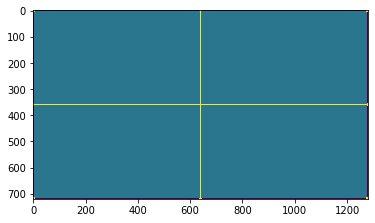

In [20]:
plt.imshow(orig)

In [21]:
print(box)

[[   0.    0.]
 [1279.    0.]
 [1279.  719.]
 [   0.  719.]]


In [22]:
 ( 100 * 267 ) / (3.2)

8343.75

# LIVE Top view camera

In [2]:
def midpoint(ptA, ptB):
	return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

In [3]:
import cv2
import pandas as pd
import numpy as np
import imutils
from scipy.spatial import distance as dist
from imutils import perspective
from imutils import contours
import matplotlib.pyplot as plt

# Real_obj_dst = (dst * objct_height_in_PIX * sensor_height_MM) / ( FL_in_MM * img_height_PIX)

In [3]:
import numpy as np
import cv2

cap = cv2.VideoCapture(1)
#saveimg = []
while(True):

    ret, frame = cap.read()


    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blank = np.zeros((frame.shape[0],frame.shape[1]))
    #_ , imgThresh = cv2.threshold(gray,80,150,cv2.THRESH_BINARY)
    gauss = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,151,15)
    imgThresh = gauss

    _,contours, hierarchy = cv2.findContours(imgThresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts = sorted(contours, key=cv2.contourArea, reverse=True)

    orig = imgThresh.copy()
    box = cv2.minAreaRect(cnts[1])
    box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
    box = np.array(box, dtype="int")


    box = perspective.order_points(box)
    cv2.drawContours(orig, [box.astype("int")], -1, (0, 255, 0), 2)
    cv2.drawContours(frame, [box.astype("int")], -1, (0, 255, 0), 2)
    cv2.drawContours(blank,cnts, -1, (255), 2)


    for i,pts in enumerate(box):
        cv2.circle(orig, (int(pts[0]), int(pts[1])), 5, 255, 5)
        cv2.circle(frame, (int(pts[0]), int(pts[1])), 5, (255,20,130), 5)
        cv2.putText(orig, "{}".format(i), (int(pts[0]), int(pts[1])), cv2.FONT_HERSHEY_SIMPLEX, 1,255, 2)
    (tl, tr, br, bl) = box
    
    # the midpoint between bottom-left and bottom-right coordinates
    (tl, tr, br, bl) = box
    (tltrX, tltrY) = midpoint(tl, tr)
    (blbrX, blbrY) = midpoint(bl, br)
     
    # compute the midpoint between the top-left and top-right points,
    # followed by the midpoint between the top-righ and bottom-right
    (tlblX, tlblY) = midpoint(tl, bl)
    (trbrX, trbrY) = midpoint(tr, br)
     
    # draw the midpoints on the image
    cv2.circle(orig, (int(tltrX), int(tltrY)), 5, (255), -1)
    '''cv2.circle(orig, (int(blbrX), int(blbrY)), 5, (255), -1)
    cv2.circle(orig, (int(tlblX), int(tlblY)), 5, (255), -1)
    cv2.circle(orig, (int(trbrX), int(trbrY)), 5, (255), -1)
    ''' 
    
    
    width = ( 180 * (tl[0] - tr[0])  * 3.3) / (3.2 * imgThresh.shape[0])
    height = ( 180 * (bl[1] - tl[1] )  * 3.3) / (3.2 * imgThresh.shape[0])
    #print(width,"Width")
    #print(height,"Height")
    cv2.putText(orig, "{} cm".format(width/10), (int(tltrX), int(tltrY)), cv2.FONT_HERSHEY_SIMPLEX, .5,0, 1 )
    cv2.putText(orig, "{} cm".format(height/10),(int(trbrX), int(trbrY)), cv2.FONT_HERSHEY_SIMPLEX, .5, 0, 1 )
    cv2.putText(frame, "{} cm".format(width/10), (int(tltrX), int(tltrY)), cv2.FONT_HERSHEY_SIMPLEX, .5, (0,0,255), 1 )
    cv2.putText(frame, "{} cm".format(height/10),(int(trbrX), int(trbrY)), cv2.FONT_HERSHEY_SIMPLEX, .5, (0,0,255), 1 )
    
    #cv2.imshow('thresh',imgThresh)
    cv2.imshow("orig",orig)
    cv2.imshow("blank",blank)
    cv2.imshow('frame',frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

# multiple objects in a frame


In [14]:
import numpy as np
import cv2

cap = cv2.VideoCapture(1)
#saveimg = []
while(True):

    ret, frame = cap.read()


    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blank = np.zeros((frame.shape[0],frame.shape[1]))
    #_ , imgThresh = cv2.threshold(gray,80,150,cv2.THRESH_BINARY)
    gauss = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,551,45)
    imgThresh = gauss

    _,contours, hierarchy = cv2.findContours(imgThresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts = sorted(contours, key=cv2.contourArea, reverse=True)

    
    for c in cnts[1:3]:
        orig = imgThresh.copy()
        box = cv2.minAreaRect(c)
        box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
        box = np.array(box, dtype="int")


        box = perspective.order_points(box)
        cv2.drawContours(orig, [box.astype("int")], -1, (0, 255, 0), 2)
        cv2.drawContours(frame, [box.astype("int")], -1, (0, 255, 0), 2)
        cv2.drawContours(blank,cnts, -1, (255), 2)


        for i,pts in enumerate(box):
            cv2.circle(orig, (int(pts[0]), int(pts[1])), 5, 255, 5)
            cv2.circle(frame, (int(pts[0]), int(pts[1])), 5, (255,20,130), 5)
            cv2.putText(orig, "{}".format(i), (int(pts[0]), int(pts[1])), cv2.FONT_HERSHEY_SIMPLEX, 1,255, 2)
        (tl, tr, br, bl) = box

        # midpoint between bottom-left and bottom-right coordinates
        (tl, tr, br, bl) = box
        (tltrX, tltrY) = midpoint(tl, tr)
        (blbrX, blbrY) = midpoint(bl, br)

        
        # midpoint between the top-righ and bottom-right
        (tlblX, tlblY) = midpoint(tl, bl)
        (trbrX, trbrY) = midpoint(tr, br)



        dstttttt = 40 *10
        width = ( dstttttt * (tl[0] - tr[0])  * 3.1) / (3.2 * imgThresh.shape[0])
        height = ( dstttttt * (bl[1] - tl[1] )  * 3.1) / (3.2 * imgThresh.shape[0])
        print(width,"Width")
        print(height,"Height")
        cv2.putText(orig, "{} cm".format(width/10), (int(tltrX), int(tltrY)), cv2.FONT_HERSHEY_SIMPLEX, .5,0, 1 )
        cv2.putText(orig, "{} cm".format(height/10),(int(trbrX), int(trbrY)), cv2.FONT_HERSHEY_SIMPLEX, .5, 0, 1 )
        cv2.putText(frame, "{} cm".format(width/10), (int(tltrX), int(tltrY)), cv2.FONT_HERSHEY_SIMPLEX, .5, (0,0,255), 1 )
        cv2.putText(frame, "{} cm".format(height/10),(int(trbrX), int(trbrY)), cv2.FONT_HERSHEY_SIMPLEX, .5, (0,0,255), 1 )

        #cv2.imshow('thresh',imgThresh)
        cv2.imshow("orig",orig)
        cv2.imshow("blank",blank)
        cv2.imshow('frame',frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

-85.03472222222223 Width
173.83680555555554 Height
-107.63888888888889 Width
18.836805555555557 Height
-85.03472222222223 Width
173.83680555555554 Height
-56.510416666666664 Width
19.375 Height
-99.02777777777777 Width
155.0 Height
-71.04166666666667 Width
16.68402777777778 Height
-85.03472222222223 Width
173.83680555555554 Height
-67.8125 Width
25.833333333333332 Height
-84.49652777777777 Width
173.29861111111111 Height
-67.27430555555556 Width
24.756944444444443 Height
-84.49652777777777 Width
173.29861111111111 Height
-68.88888888888889 Width
23.680555555555557 Height
-85.03472222222223 Width
173.29861111111111 Height
-68.35069444444444 Width
23.680555555555557 Height
-85.03472222222223 Width
173.29861111111111 Height
-68.35069444444444 Width
23.680555555555557 Height
-85.03472222222223 Width
173.29861111111111 Height
-68.88888888888889 Width
24.756944444444443 Height
-84.49652777777777 Width
173.29861111111111 Height
-68.35069444444444 Width
23.680555555555557 Height
-85.0347222222

-84.49652777777777 Width
173.29861111111111 Height
-79.11458333333333 Width
17.22222222222222 Height
-85.03472222222223 Width
173.29861111111111 Height
-78.57638888888889 Width
17.22222222222222 Height
-85.03472222222223 Width
173.83680555555554 Height
-78.57638888888889 Width
28.524305555555557 Height
-85.03472222222223 Width
173.83680555555554 Height
-78.57638888888889 Width
29.0625 Height
-85.03472222222223 Width
173.83680555555554 Height
-79.11458333333333 Width
17.22222222222222 Height
-85.03472222222223 Width
173.83680555555554 Height
-79.11458333333333 Width
29.0625 Height
-85.03472222222223 Width
173.29861111111111 Height
-79.11458333333333 Width
28.524305555555557 Height
-85.03472222222223 Width
173.83680555555554 Height
-85.57291666666667 Width
29.600694444444443 Height
-85.03472222222223 Width
173.83680555555554 Height
-85.03472222222223 Width
29.0625 Height
-84.49652777777777 Width
173.29861111111111 Height
-79.11458333333333 Width
17.22222222222222 Height
-84.4965277777777

-84.49652777777777 Width
173.29861111111111 Height
-17.22222222222222 Width
6.458333333333333 Height
-85.03472222222223 Width
173.29861111111111 Height
-52.74305555555556 Width
25.833333333333332 Height
-85.03472222222223 Width
173.29861111111111 Height
-48.97569444444444 Width
16.68402777777778 Height
-85.03472222222223 Width
173.83680555555554 Height
-48.4375 Width
16.68402777777778 Height
-85.03472222222223 Width
173.83680555555554 Height
-47.89930555555556 Width
16.145833333333332 Height
-85.03472222222223 Width
173.83680555555554 Height
-46.822916666666664 Width
15.60763888888889 Height
-84.49652777777777 Width
173.29861111111111 Height
-47.361111111111114 Width
15.60763888888889 Height
-85.03472222222223 Width
173.29861111111111 Height
-47.361111111111114 Width
16.145833333333332 Height
-85.03472222222223 Width
173.29861111111111 Height
-46.822916666666664 Width
16.145833333333332 Height
-85.03472222222223 Width
173.29861111111111 Height
-47.361111111111114 Width
16.1458333333333

-85.03472222222223 Width
173.83680555555554 Height
-57.048611111111114 Width
17.22222222222222 Height
-85.03472222222223 Width
173.83680555555554 Height
-57.58680555555556 Width
24.756944444444443 Height
-85.03472222222223 Width
173.83680555555554 Height
-57.048611111111114 Width
24.756944444444443 Height
-85.03472222222223 Width
173.29861111111111 Height
-57.048611111111114 Width
24.756944444444443 Height
-84.49652777777777 Width
173.83680555555554 Height
-55.97222222222222 Width
25.833333333333332 Height
-85.03472222222223 Width
173.83680555555554 Height
-56.510416666666664 Width
29.0625 Height
-85.03472222222223 Width
173.29861111111111 Height
-57.58680555555556 Width
28.524305555555557 Height
-85.03472222222223 Width
173.29861111111111 Height
-59.201388888888886 Width
30.13888888888889 Height
-84.49652777777777 Width
172.76041666666666 Height
-34.982638888888886 Width
18.29861111111111 Height
-83.42013888888889 Width
172.22222222222223 Height
-50.59027777777778 Width
25.83333333333

-85.03472222222223 Width
178.14236111111111 Height
-76.96180555555556 Width
20.45138888888889 Height
-85.03472222222223 Width
178.14236111111111 Height
-78.03819444444444 Width
22.604166666666668 Height
-85.03472222222223 Width
178.68055555555554 Height
-73.73263888888889 Width
16.68402777777778 Height
-85.03472222222223 Width
178.14236111111111 Height
-27.98611111111111 Width
12.378472222222221 Height
-85.03472222222223 Width
178.14236111111111 Height
-27.98611111111111 Width
12.378472222222221 Height
-85.03472222222223 Width
178.14236111111111 Height
-22.06597222222222 Width
7.534722222222222 Height
-85.03472222222223 Width
178.14236111111111 Height
-2.1527777777777777 Width
1.6145833333333333 Height
-85.03472222222223 Width
178.14236111111111 Height
-27.98611111111111 Width
12.378472222222221 Height
-85.03472222222223 Width
178.68055555555554 Height
-27.98611111111111 Width
12.378472222222221 Height
-85.03472222222223 Width
178.14236111111111 Height
-27.98611111111111 Width
12.91666

-12.378472222222221 Width
5.381944444444445 Height
-4.84375 Width
1.0763888888888888 Height
-30.13888888888889 Width
6.458333333333333 Height
-12.916666666666666 Width
4.305555555555555 Height
-2.1527777777777777 Width
5.920138888888889 Height
-2.6909722222222223 Width
4.84375 Height
-7.534722222222222 Width
3.767361111111111 Height
-3.2291666666666665 Width
6.458333333333333 Height
-120.01736111111111 Width
219.04513888888889 Height
-11.840277777777779 Width
22.604166666666668 Height
-114.63541666666667 Width
195.36458333333334 Height
-1.6145833333333333 Width
13.993055555555555 Height
-83.42013888888889 Width
243.80208333333334 Height
-38.21180555555556 Width
28.524305555555557 Height
-83.42013888888889 Width
174.91319444444446 Height
-24.756944444444443 Width
9.149305555555555 Height
-83.42013888888889 Width
174.91319444444446 Height
-2.6909722222222223 Width
10.225694444444445 Height
-83.42013888888889 Width
174.91319444444446 Height
-6.996527777777778 Width
5.920138888888889 Heigh

-83.42013888888889 Width
121.63194444444444 Height
-61.892361111111114 Width
30.677083333333332 Height
-82.88194444444444 Width
117.32638888888889 Height
-61.892361111111114 Width
29.600694444444443 Height
-82.34375 Width
111.94444444444444 Height
-61.892361111111114 Width
29.0625 Height
-82.88194444444444 Width
109.79166666666667 Height
-58.125 Width
37.673611111111114 Height
-82.88194444444444 Width
105.48611111111111 Height
-61.892361111111114 Width
29.0625 Height
-82.34375 Width
104.40972222222223 Height
-61.892361111111114 Width
30.13888888888889 Height
-82.88194444444444 Width
99.56597222222223 Height
-61.892361111111114 Width
30.13888888888889 Height
-83.42013888888889 Width
94.18402777777777 Height
-45.74652777777778 Width
16.145833333333332 Height
-83.42013888888889 Width
88.80208333333333 Height
-54.357638888888886 Width
19.913194444444443 Height
-86.64930555555556 Width
83.42013888888889 Height
-44.13194444444444 Width
17.22222222222222 Height
-86.64930555555556 Width
86.111

-85.03472222222223 Width
177.06597222222223 Height
-44.13194444444444 Width
24.756944444444443 Height
-85.03472222222223 Width
177.06597222222223 Height
-43.05555555555556 Width
24.756944444444443 Height
-85.03472222222223 Width
177.06597222222223 Height
-42.517361111111114 Width
24.756944444444443 Height
-85.03472222222223 Width
177.06597222222223 Height
-43.05555555555556 Width
24.756944444444443 Height
-85.03472222222223 Width
177.06597222222223 Height
-42.517361111111114 Width
24.756944444444443 Height
-85.03472222222223 Width
176.52777777777777 Height
-43.05555555555556 Width
24.756944444444443 Height
-85.03472222222223 Width
176.52777777777777 Height
-41.979166666666664 Width
25.29513888888889 Height
-85.03472222222223 Width
176.52777777777777 Height
-45.208333333333336 Width
35.520833333333336 Height
-85.03472222222223 Width
177.06597222222223 Height
-27.98611111111111 Width
12.378472222222221 Height
-85.03472222222223 Width
176.52777777777777 Height
-27.98611111111111 Width
7.5

-85.03472222222223 Width
177.06597222222223 Height
-2.1527777777777777 Width
2.1527777777777777 Height
-85.03472222222223 Width
177.06597222222223 Height
-3.2291666666666665 Width
2.1527777777777777 Height
-85.03472222222223 Width
177.06597222222223 Height
-7.534722222222222 Width
2.6909722222222223 Height
-85.03472222222223 Width
177.06597222222223 Height
-2.1527777777777777 Width
5.920138888888889 Height
-85.03472222222223 Width
177.06597222222223 Height
-3.767361111111111 Width
5.381944444444445 Height
-85.03472222222223 Width
177.06597222222223 Height
-30.13888888888889 Width
9.149305555555555 Height
-85.03472222222223 Width
176.52777777777777 Height
-6.996527777777778 Width
2.1527777777777777 Height
-85.03472222222223 Width
176.52777777777777 Height
-37.673611111111114 Width
8.61111111111111 Height
-85.03472222222223 Width
177.06597222222223 Height
-9.149305555555555 Width
5.381944444444445 Height
-85.03472222222223 Width
176.52777777777777 Height
-4.84375 Width
2.1527777777777777

-85.57291666666667 Width
173.83680555555554 Height
-15.60763888888889 Width
5.920138888888889 Height
-85.57291666666667 Width
173.83680555555554 Height
-16.68402777777778 Width
8.072916666666666 Height
-85.03472222222223 Width
173.83680555555554 Height
-9.149305555555555 Width
3.767361111111111 Height
-85.57291666666667 Width
173.83680555555554 Height
-16.145833333333332 Width
6.996527777777778 Height
-85.03472222222223 Width
174.375 Height
-13.45486111111111 Width
8.61111111111111 Height
-85.03472222222223 Width
173.83680555555554 Height
-16.145833333333332 Width
8.61111111111111 Height
-85.57291666666667 Width
173.83680555555554 Height
-15.60763888888889 Width
7.534722222222222 Height
-85.03472222222223 Width
173.83680555555554 Height
-6.996527777777778 Width
0.5381944444444444 Height
-85.57291666666667 Width
173.83680555555554 Height
-13.993055555555555 Width
6.458333333333333 Height
-85.03472222222223 Width
173.83680555555554 Height
-19.913194444444443 Width
9.149305555555555 Heigh

-174.375 Width
86.64930555555556 Height
-58.66319444444444 Width
13.993055555555555 Height
-174.375 Width
86.64930555555556 Height
-67.27430555555556 Width
19.375 Height
-174.375 Width
87.1875 Height
-65.12152777777777 Width
17.22222222222222 Height
-174.375 Width
86.64930555555556 Height
-61.354166666666664 Width
16.145833333333332 Height
-174.375 Width
86.64930555555556 Height
-52.74305555555556 Width
16.68402777777778 Height
-174.375 Width
86.64930555555556 Height
-27.98611111111111 Width
12.378472222222221 Height
-174.91319444444446 Width
86.64930555555556 Height
-27.98611111111111 Width
10.225694444444445 Height
-174.375 Width
86.64930555555556 Height
-27.98611111111111 Width
12.378472222222221 Height
-174.91319444444446 Width
86.64930555555556 Height
-27.447916666666668 Width
10.225694444444445 Height
-174.91319444444446 Width
86.64930555555556 Height
-26.90972222222222 Width
12.378472222222221 Height
-174.91319444444446 Width
86.64930555555556 Height
-27.98611111111111 Width
12.

-120.55555555555556 Width
76.42361111111111 Height
-24.21875 Width
10.225694444444445 Height
-120.55555555555556 Width
76.42361111111111 Height
-22.06597222222222 Width
9.6875 Height
-120.55555555555556 Width
76.42361111111111 Height
-23.14236111111111 Width
10.225694444444445 Height
-120.55555555555556 Width
76.42361111111111 Height
-25.29513888888889 Width
9.6875 Height
-117.32638888888889 Width
78.03819444444444 Height
-30.677083333333332 Width
10.225694444444445 Height
-119.47916666666667 Width
79.11458333333333 Height
-9.149305555555555 Width
3.2291666666666665 Height
-121.09375 Width
80.72916666666667 Height
-30.13888888888889 Width
10.225694444444445 Height
-130.24305555555554 Width
83.42013888888889 Height
-4.305555555555555 Width
12.378472222222221 Height
-134.54861111111111 Width
76.96180555555556 Height
-26.90972222222222 Width
10.76388888888889 Height
-134.01041666666666 Width
70.50347222222223 Height
-31.75347222222222 Width
98.48958333333333 Height
-132.93402777777777 Wid

-132.39583333333334 Width
71.57986111111111 Height
-26.90972222222222 Width
6.996527777777778 Height
-132.39583333333334 Width
71.57986111111111 Height
-27.447916666666668 Width
6.458333333333333 Height
-131.85763888888889 Width
71.57986111111111 Height
-23.680555555555557 Width
7.534722222222222 Height
-131.85763888888889 Width
71.57986111111111 Height
-39.28819444444444 Width
7.534722222222222 Height
-132.39583333333334 Width
71.57986111111111 Height
-23.680555555555557 Width
6.458333333333333 Height
-131.85763888888889 Width
71.57986111111111 Height
-27.98611111111111 Width
5.920138888888889 Height
-131.85763888888889 Width
71.57986111111111 Height
-26.90972222222222 Width
6.458333333333333 Height
-132.39583333333334 Width
71.57986111111111 Height
-27.98611111111111 Width
6.996527777777778 Height
-132.39583333333334 Width
71.57986111111111 Height
-27.447916666666668 Width
6.996527777777778 Height
-132.39583333333334 Width
71.57986111111111 Height
-27.447916666666668 Width
6.45833333

-3.767361111111111 Width
6.458333333333333 Height
-2.1527777777777777 Width
9.6875 Height
-8.072916666666666 Width
2.1527777777777777 Height
-7.534722222222222 Width
2.1527777777777777 Height
-4.305555555555555 Width
7.534722222222222 Height
-2.1527777777777777 Width
10.76388888888889 Height
-2.1527777777777777 Width
8.072916666666666 Height
-6.996527777777778 Width
2.6909722222222223 Height
-10.225694444444445 Width
2.1527777777777777 Height
-1.6145833333333333 Width
9.149305555555555 Height
-1.6145833333333333 Width
10.76388888888889 Height
-3.2291666666666665 Width
2.1527777777777777 Height
-2.1527777777777777 Width
9.6875 Height
-2.6909722222222223 Width
4.84375 Height
-2.1527777777777777 Width
9.149305555555555 Height
-4.84375 Width
2.1527777777777777 Height
-4.84375 Width
8.61111111111111 Height
-2.6909722222222223 Width
8.072916666666666 Height
-11.302083333333334 Width
3.2291666666666665 Height
-3.767361111111111 Width
9.6875 Height
-10.76388888888889 Width
24.21875 Height
-7.5

-1.0763888888888888 Width
12.916666666666666 Height
-2.1527777777777777 Width
5.381944444444445 Height
-4.84375 Width
28.524305555555557 Height
-2.6909722222222223 Width
13.45486111111111 Height
-2.1527777777777777 Width
5.920138888888889 Height
-2.6909722222222223 Width
4.84375 Height
-1.0763888888888888 Width
12.916666666666666 Height
-2.1527777777777777 Width
6.458333333333333 Height
-1.6145833333333333 Width
11.302083333333334 Height
-2.1527777777777777 Width
7.534722222222222 Height
-4.84375 Width
29.0625 Height
-1.6145833333333333 Width
12.378472222222221 Height
-5.381944444444445 Width
0.5381944444444444 Height
-2.1527777777777777 Width
5.920138888888889 Height
-1.6145833333333333 Width
12.916666666666666 Height
-2.1527777777777777 Width
5.381944444444445 Height
-1.6145833333333333 Width
12.378472222222221 Height
-2.1527777777777777 Width
4.84375 Height
-2.1527777777777777 Width
11.302083333333334 Height
-2.1527777777777777 Width
5.381944444444445 Height
-1.6145833333333333 Widt

-13.45486111111111 Width
4.84375 Height
-2.1527777777777777 Width
5.381944444444445 Height
-4.84375 Width
0.5381944444444444 Height
-2.1527777777777777 Width
14.53125 Height
-2.6909722222222223 Width
5.381944444444445 Height
-2.1527777777777777 Width
5.381944444444445 Height
-13.45486111111111 Width
4.305555555555555 Height
-5.381944444444445 Width
0.5381944444444444 Height
-12.378472222222221 Width
4.305555555555555 Height
-1.6145833333333333 Width
11.302083333333334 Height
-10.76388888888889 Width
4.84375 Height
-2.6909722222222223 Width
5.381944444444445 Height
-5.381944444444445 Width
0.5381944444444444 Height
-1.6145833333333333 Width
11.302083333333334 Height
-2.1527777777777777 Width
11.302083333333334 Height
-2.1527777777777777 Width
5.920138888888889 Height
-1.0763888888888888 Width
14.53125 Height
-2.6909722222222223 Width
4.84375 Height
-14.53125 Width
5.381944444444445 Height
-8.61111111111111 Width
2.6909722222222223 Height
-9.6875 Width
4.84375 Height
-1.6145833333333333 

-2.1527777777777777 Width
5.381944444444445 Height
-1.6145833333333333 Width
7.534722222222222 Height
-6.458333333333333 Width
3.767361111111111 Height
-2.1527777777777777 Width
5.381944444444445 Height
-2.1527777777777777 Width
4.84375 Height
-2.1527777777777777 Width
6.458333333333333 Height
-2.6909722222222223 Width
4.305555555555555 Height
-2.1527777777777777 Width
5.920138888888889 Height
-2.6909722222222223 Width
8.072916666666666 Height
-5.920138888888889 Width
2.6909722222222223 Height
-9.6875 Width
3.767361111111111 Height
-2.1527777777777777 Width
4.84375 Height
-2.6909722222222223 Width
4.84375 Height
-2.1527777777777777 Width
5.381944444444445 Height
-2.1527777777777777 Width
5.381944444444445 Height
-2.1527777777777777 Width
4.84375 Height
-1.6145833333333333 Width
9.149305555555555 Height
-2.6909722222222223 Width
5.381944444444445 Height
-4.84375 Width
3.2291666666666665 Height
-1.6145833333333333 Width
9.6875 Height
-12.916666666666666 Width
4.84375 Height
-9.1493055555

-5.920138888888889 Width
13.45486111111111 Height
-13.993055555555555 Width
5.381944444444445 Height
-11.840277777777779 Width
18.29861111111111 Height
-5.381944444444445 Width
0.5381944444444444 Height
-11.840277777777779 Width
18.29861111111111 Height
-1.6145833333333333 Width
12.916666666666666 Height
-10.225694444444445 Width
13.45486111111111 Height
-11.840277777777779 Width
5.381944444444445 Height
-10.225694444444445 Width
13.993055555555555 Height
-3.2291666666666665 Width
11.840277777777779 Height
-11.302083333333334 Width
18.29861111111111 Height
-5.381944444444445 Width
0.5381944444444444 Height
-10.76388888888889 Width
13.45486111111111 Height
-4.84375 Width
12.916666666666666 Height
-495.6770833333333 Width
13.45486111111111 Height
-10.76388888888889 Width
13.45486111111111 Height
-11.302083333333334 Width
13.45486111111111 Height
-4.84375 Width
13.45486111111111 Height
-10.225694444444445 Width
13.45486111111111 Height
-4.305555555555555 Width
12.916666666666666 Height
-1

-6.458333333333333 Width
13.993055555555555 Height
-4.84375 Width
13.45486111111111 Height
-11.840277777777779 Width
17.760416666666668 Height
-10.225694444444445 Width
5.381944444444445 Height
-10.225694444444445 Width
13.993055555555555 Height
-11.840277777777779 Width
4.84375 Height
-10.76388888888889 Width
13.45486111111111 Height
-15.069444444444445 Width
4.84375 Height
-10.225694444444445 Width
13.993055555555555 Height
-12.378472222222221 Width
4.305555555555555 Height
-11.302083333333334 Width
54.895833333333336 Height
-97.41319444444444 Width
1.6145833333333333 Height
-6.458333333333333 Width
13.993055555555555 Height
-6.458333333333333 Width
12.378472222222221 Height
-11.302083333333334 Width
13.45486111111111 Height
-6.458333333333333 Width
12.916666666666666 Height
-11.302083333333334 Width
13.45486111111111 Height
-12.378472222222221 Width
4.84375 Height
-11.302083333333334 Width
13.993055555555555 Height
-10.76388888888889 Width
4.305555555555555 Height
-10.76388888888889

-5.920138888888889 Width
13.993055555555555 Height
-5.920138888888889 Width
18.29861111111111 Height
-11.302083333333334 Width
13.45486111111111 Height
-9.149305555555555 Width
4.84375 Height
-10.225694444444445 Width
13.993055555555555 Height
-4.305555555555555 Width
12.916666666666666 Height
-11.302083333333334 Width
18.29861111111111 Height
-2.6909722222222223 Width
0.5381944444444444 Height
-6.996527777777778 Width
15.069444444444445 Height
-4.84375 Width
12.916666666666666 Height
-11.302083333333334 Width
13.45486111111111 Height
-4.305555555555555 Width
12.378472222222221 Height
-11.302083333333334 Width
13.45486111111111 Height
-5.381944444444445 Width
12.916666666666666 Height
-11.302083333333334 Width
13.45486111111111 Height
-11.302083333333334 Width
5.381944444444445 Height
-11.302083333333334 Width
13.45486111111111 Height
-5.920138888888889 Width
12.378472222222221 Height
-5.920138888888889 Width
13.993055555555555 Height
-5.920138888888889 Width
12.916666666666666 Height


-38.21180555555556 Width
7.534722222222222 Height
-11.302083333333334 Width
18.836805555555557 Height
-29.600694444444443 Width
7.534722222222222 Height
-11.302083333333334 Width
13.45486111111111 Height
-27.447916666666668 Width
10.225694444444445 Height
-11.302083333333334 Width
13.45486111111111 Height
-10.225694444444445 Width
13.993055555555555 Height
-4.305555555555555 Width
12.378472222222221 Height
-11.302083333333334 Width
13.45486111111111 Height
-4.305555555555555 Width
12.378472222222221 Height
-11.302083333333334 Width
13.993055555555555 Height
-5.920138888888889 Width
12.916666666666666 Height
-11.302083333333334 Width
13.45486111111111 Height
-10.76388888888889 Width
10.225694444444445 Height
-10.76388888888889 Width
18.29861111111111 Height
-2.1527777777777777 Width
5.381944444444445 Height
-11.302083333333334 Width
13.45486111111111 Height
-4.84375 Width
12.916666666666666 Height
-11.302083333333334 Width
13.45486111111111 Height
-5.920138888888889 Width
12.91666666666

## single image 

In [13]:
import numpy as np
import cv2



frame = cv2.imread("C:/Users/shrin/Downloads/test_img_2.jfif")


gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
blank = np.zeros((frame.shape[0],frame.shape[1]))
#_ , imgThresh = cv2.threshold(gray,80,150,cv2.THRESH_BINARY)
gauss = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,111,10)
imgThresh = gauss

_,contours, hierarchy = cv2.findContours(imgThresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = sorted(contours, key=cv2.contourArea, reverse=True)

orig = imgThresh.copy()
box = cv2.minAreaRect(cnts[1])
box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
box = np.array(box, dtype="int")


box = perspective.order_points(box)
cv2.drawContours(orig, [box.astype("int")], -1, (0, 255, 0), 2)
cv2.drawContours(frame, [box.astype("int")], -1, (0, 255, 0), 2)
cv2.drawContours(blank,cnts, -1, (255), 2)


for i,pts in enumerate(box):
    cv2.circle(orig, (int(pts[0]), int(pts[1])), 5, 255, 5)
    cv2.circle(frame, (int(pts[0]), int(pts[1])), 5, (255,20,130), 5)
    cv2.putText(orig, "{}".format(i), (int(pts[0]), int(pts[1])), cv2.FONT_HERSHEY_SIMPLEX, 1,255, 2)
(tl, tr, br, bl) = box

# the midpoint between bottom-left and bottom-right coordinates
(tl, tr, br, bl) = box
(tltrX, tltrY) = midpoint(tl, tr)
(blbrX, blbrY) = midpoint(bl, br)

# compute the midpoint between the top-left and top-right points,
# followed by the midpoint between the top-righ and bottom-right
(tlblX, tlblY) = midpoint(tl, bl)
(trbrX, trbrY) = midpoint(tr, br)

# draw the midpoints on the image
cv2.circle(orig, (int(tltrX), int(tltrY)), 5, (255), -1)
'''cv2.circle(orig, (int(blbrX), int(blbrY)), 5, (255), -1)
cv2.circle(orig, (int(tlblX), int(tlblY)), 5, (255), -1)
cv2.circle(orig, (int(trbrX), int(trbrY)), 5, (255), -1)
''' 


width = ( 390 * (tl[0] - tr[0])  * 3) / (3.2 * imgThresh.shape[0])
height = ( 390 * (bl[1] - tl[1] )  * 3) / (3.2 * imgThresh.shape[0])
#print(width,"Width")
#print(height,"Height")
cv2.putText(orig, "{} cm".format(width/10), (int(tltrX), int(tltrY)), cv2.FONT_HERSHEY_SIMPLEX, .5,0, 1 )
cv2.putText(orig, "{} cm".format(height/10),(int(trbrX), int(trbrY)), cv2.FONT_HERSHEY_SIMPLEX, .5, 0, 1 )
cv2.putText(frame, "{} cm".format(width/10), (int(tltrX), int(tltrY)), cv2.FONT_HERSHEY_SIMPLEX, .5, (0,0,255), 1 )
cv2.putText(frame, "{} cm".format(height/10),(int(trbrX), int(trbrY)), cv2.FONT_HERSHEY_SIMPLEX, .5, (0,0,255), 1 )

#cv2.imshow('thresh',imgThresh)
cv2.imshow("orig",orig)
cv2.imshow("blank",blank)
cv2.imshow('frame',frame)
cv2.waitKey(0)
cv2.destroyAllWindows()